In [62]:
import pandas as pd
from scipy.io import arff
import re

# Carica il file ARFF
data, meta = arff.loadarff("jsbachchoralharmony.arff")
df = pd.DataFrame(data)

def decode_if_bytes(x):
    if isinstance(x, bytes):
        return x.decode("utf-8")
    return x

df = df.applymap(decode_if_bytes)

# Controlliamo le colonne
print(df.columns)

# Supponiamo che le colonne finali siano tipo: root, val, target
# 1. Rimuovere 'root'
df = df.drop(columns=["V15"])

# 2. Mappare il target agli accordi Major/Minor
def simplify_target(chord):
    chord = chord.decode("utf-8") if isinstance(chord, bytes) else chord

    # Normalizziamo underscore/maiuscole
    chord = chord.replace("_", "").strip()

    # Maj
    if chord.endswith("M"):
        return "Major"
    # Min
    elif chord.endswith("m"):
        return "Minor"
    # Dominant 7th
    elif chord.endswith("M7"):
        return "Dominant7th"
    # Min 7th
    elif chord.endswith("m7"):
        return "Minor7"
    # Sus
    elif chord.endswith("m4"):
        return "Sus4_min"
    elif chord.endswith("M4"):
        return "Sus4_maj"
    # Diminished
    elif chord.endswith("d"):
        return "Diminished"
    # HalfDiminished
    elif chord.endswith("d7"):
        return "HalfDiminished"
    # Dim 6th
    elif chord.endswith("d6"):
        return "Diminished6"
    # Maj 6th
    elif chord.endswith("M6"):
        return "Major6"
    # Min 6th
    elif chord.endswith("m6"):
        return "Minor6"

df["V17"] = df["V17"].apply(simplify_target)

print(df.head())



Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17'],
      dtype='object')
         V1   V2   V3   V4   V5   V6   V7   V8   V9  V10  V11  V12  V13  V14  \
0  000106b_  1.0  YES   NO   NO   NO   NO  YES   NO   NO   NO  YES   NO   NO   
1  000106b_  2.0  YES   NO   NO   NO  YES   NO   NO  YES   NO   NO   NO   NO   
2  000106b_  3.0  YES   NO   NO   NO  YES   NO   NO  YES   NO   NO   NO   NO   
3  000106b_  4.0  YES   NO   NO   NO   NO  YES   NO   NO   NO  YES   NO   NO   
4  000106b_  5.0  YES   NO   NO   NO   NO  YES   NO   NO   NO  YES   NO   NO   

   V16    V17  
0  3.0  Major  
1  5.0  Major  
2  2.0  Major  
3  3.0  Major  
4  2.0  Major  


C:\Users\Lorenzo\AppData\Local\Temp\ipykernel_43824\1423968662.py:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.


In [ ]:
import pandas as pd
from sklearn.model_selection import train_train_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt


# tieni solo le feature da V2 a V16
x = df.loc[:, "V2":"V16"].replace({"YES": 1, " NO": 0})

# target semplificato
y = df["V17"]

print(x.head())
print(y.head())

    V2  V3  V4  V5  V6  V7  V8  V9  V10  V11  V12  V13  V14  V16
0  1.0   1   0   0   0   0   1   0    0    0    1    0    0  3.0
1  2.0   1   0   0   0   1   0   0    1    0    0    0    0  5.0
2  3.0   1   0   0   0   1   0   0    1    0    0    0    0  2.0
3  4.0   1   0   0   0   0   1   0    0    0    1    0    0  3.0
4  5.0   1   0   0   0   0   1   0    0    0    1    0    0  2.0
0    Major
1    Major
2    Major
3    Major
4    Major
Name: V17, dtype: object


C:\Users\Lorenzo\AppData\Local\Temp\ipykernel_43824\71980218.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from dtreeviz.trees import model
from sklearn import metrics
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.tree import plot_tree

def plot_dataset_(X, y, axes, x1_index=0, x2_index=1, labels=[]):
    if axes != []:
        plt.axis(axes)
    else:
        plt.figure(figsize=(8, 6))
    for item, style in zip(set(y), ["bs", "g^", "yo", "cv", "m<", "r<"]):
        if item == -1: # style for bad predictions
            style = "rx"
        plt.plot(X[:, 0][y==item], X[:, 1][y==item], style)
    plt.grid(True, which='both')
    if labels != []:
        plt.xlabel(labels[x1_index], fontsize=12)
        plt.ylabel(labels[x2_index], fontsize=12)
    else:
        plt.xlabel(r"$x_1$", fontsize=12)
        plt.ylabel(r"$x_2$", fontsize=12, rotation=0)
    return


def plot_dataset(X, y, title, x1_index=0, x2_index=1, labels=[]):
    plt.figure(figsize=(8, 6))
    plot_dataset_(X, y, [], x1_index=x1_index, x2_index=x2_index, labels=labels)
    plt.title(title)
    plt.show()
    return


def plot_predictions(clf, axes, confidence=True):
    plt.figure(figsize=(8, 6))
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X_ = np.c_[x0.ravel(), x1.ravel()]
    y_pred = np.array(clf.predict(X_)).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    #plot confidence scores for samples
    if confidence:
        y_decision = clf.decision_function(X_).reshape(x0.shape)
        plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)
    return


def plot_classification_results(X, y, clf=None, predicted_y=[], axes=[], confidence=False, title=""):
    if len(axes) == 0:
        for i in [0,1]:
            min_x = min(X[:,i])
            max_x = max(X[:,i])
            delta_x = (max_x-min_x)/20
            axes += [min_x-delta_x, max_x+delta_x]
    if clf != None:
        plot_predictions(clf, axes, confidence=confidence)
    if len(predicted_y) > 0:
        res_y = np.array([el1 if (el1==el2) else -1 for el1,el2 in zip(y, predicted_y)])
        plot_dataset_(X, res_y, axes)
    else:
        plot_dataset_(X, y, axes)
    plt.title(title)
    plt.show()
    return


def print_classification_metrics(test_labels, predicted_labels, average='binary', prefix=""):
    accuracy = metrics.accuracy_score(test_labels, predicted_labels)
    precision = metrics.precision_score(test_labels, predicted_labels, average=average,zero_division=0)
    recall = metrics.recall_score(test_labels, predicted_labels, average=average,zero_division=0)
    F1 = metrics.f1_score(test_labels, predicted_labels, average=average,zero_division=0)
    print(prefix+"Accuracy: {:.5f}".format(accuracy), "Precision: {:.5f}".format(
        precision), "Recall: {:.5f}".format(recall), "F1: {:.5f}".format(F1), sep='\n')


def show_tree(classifier):
    plt.figure(figsize=(50, 50))
    plot_tree(
        classifier, 
        filled=True, 
        rounded=True, 
        class_names=y.unique(), 
        feature_names=list(x),
        fontsize=5
            )

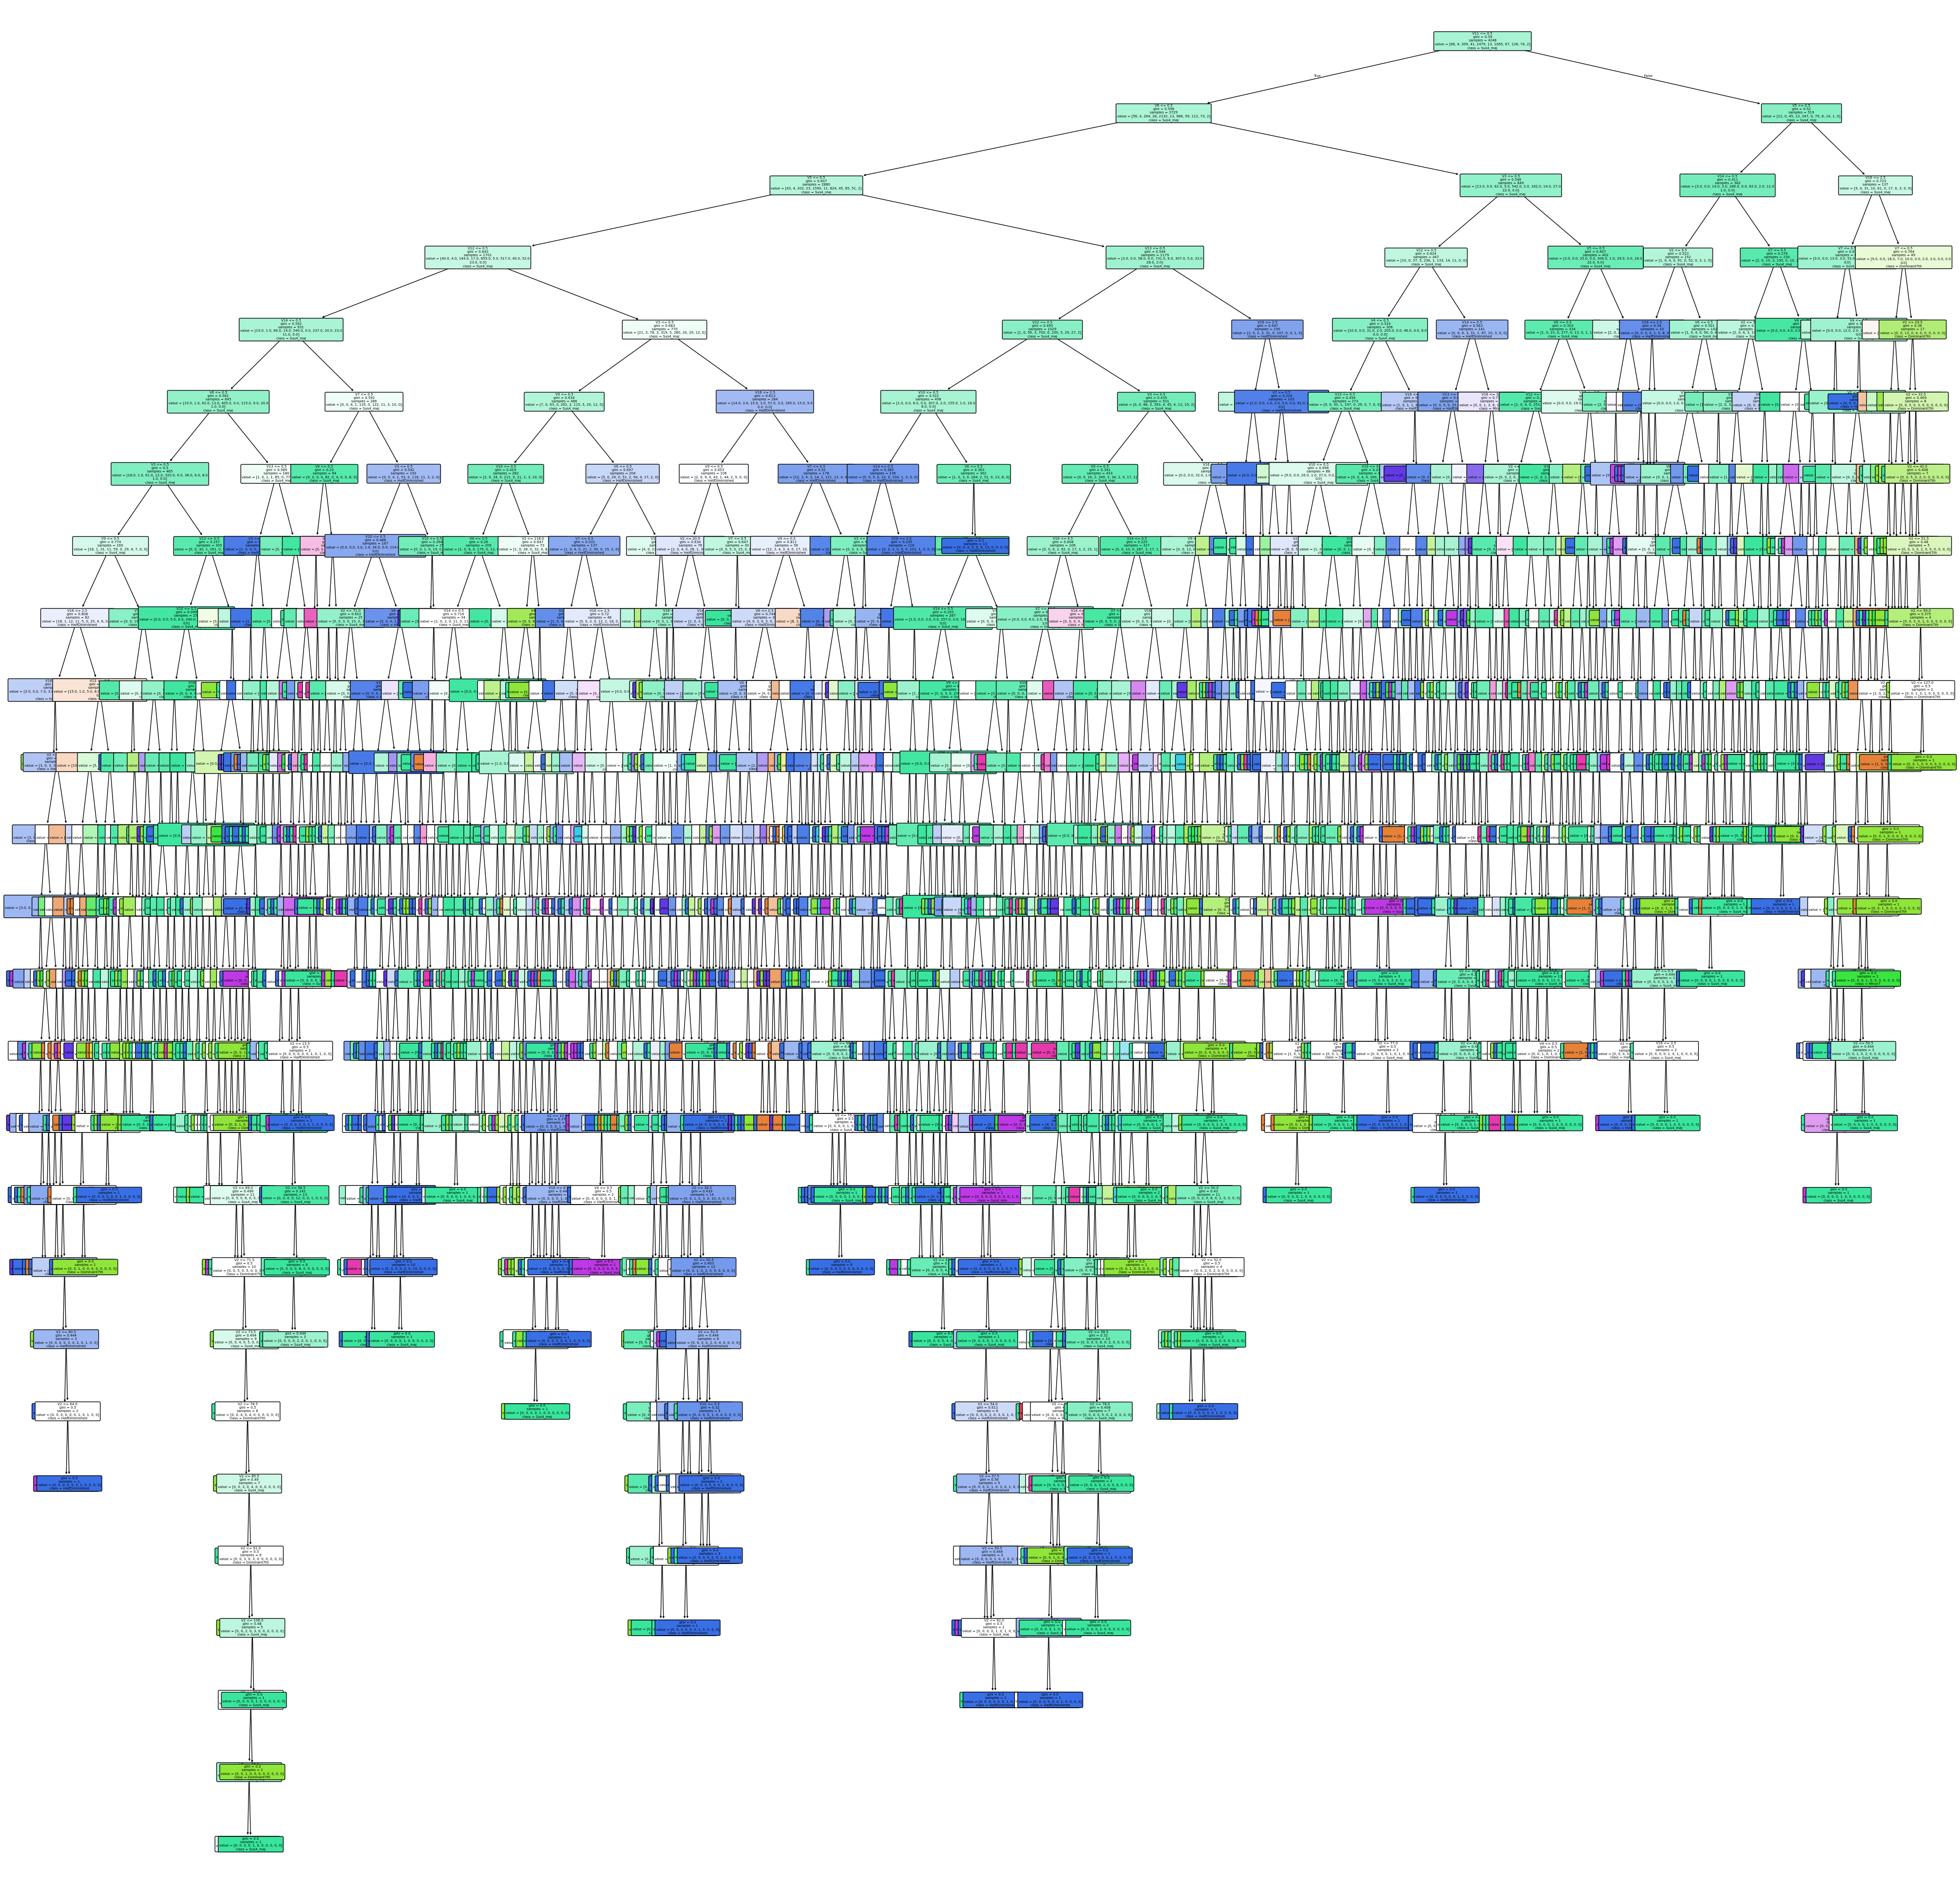

In [78]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

# split dataset into training and test sets
training_data, test_data, training_labels, test_labels = train_test_split(x, y, test_size=0.25, random_state=0)

# initialize classifier with hyperparameters, the default one in this case
classifier = DecisionTreeClassifier()

# train classifier with training set
classifier.fit(training_data, training_labels)

predicted_train = classifier.predict(training_data)

show_tree(classifier)

In [80]:
classifier = DecisionTreeClassifier()
classifier.fit(training_data, training_labels)

predicted = classifier.predict(test_data)

# print classification metrics (macro)
print_classification_metrics(
    test_labels, predicted, average='macro', prefix="## Macro metrics ## ")
print()
print_classification_metrics(
    test_labels, predicted, average='micro', prefix="## Micro metrics ## ")

## Macro metrics ## Accuracy: 0.72195
Precision: 0.39221
Recall: 0.40596
F1: 0.39381

## Micro metrics ## Accuracy: 0.72195
Precision: 0.72195
Recall: 0.72195
F1: 0.72195


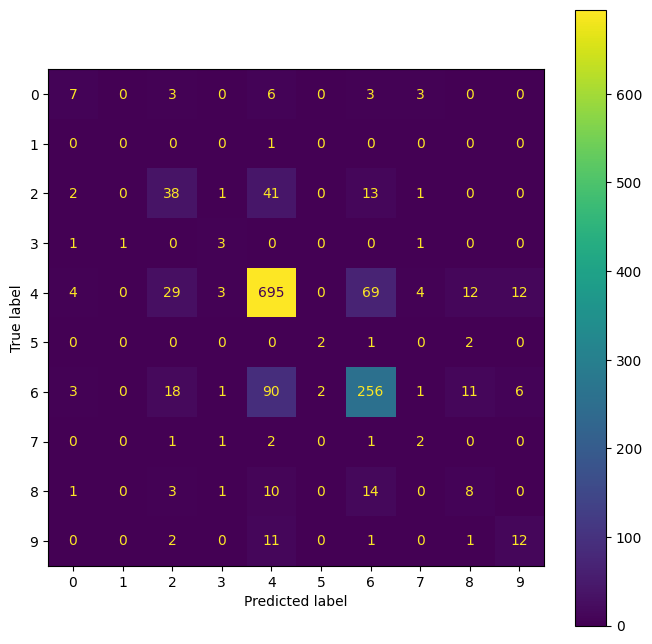

In [81]:
from sklearn.metrics import ConfusionMatrixDisplay
cmp = ConfusionMatrixDisplay(confusion_matrix(test_labels, predicted))
fig, ax = plt.subplots(figsize=(8, 8))
cmp.plot(ax=ax)
plt.show()

## Macro metrics ## Accuracy: 0.14961
Precision: 0.19467
Recall: 0.07845
F1: 0.03577

## Micro metrics ## Accuracy: 0.14961
Precision: 0.14961
Recall: 0.14961
F1: 0.14961


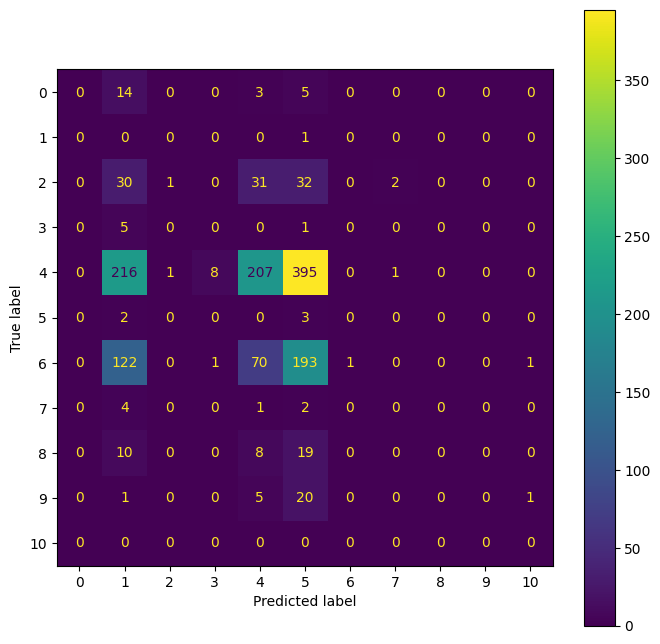

In [91]:
# naive bayes classifier
from sklearn.naive_bayes import GaussianNB

# initialize classifier with hyperparameters
classifier = GaussianNB()

# train classifier with training set
classifier.fit(training_data.values, training_labels)

# use trained classifecation model to predict classes on test set
predicted = classifier.predict(test_data.values)

# print classification metrics (macro)
print_classification_metrics(
    test_labels, predicted, average='macro', prefix="## Macro metrics ## ")
print()
print_classification_metrics(
    test_labels, predicted, average='micro', prefix="## Micro metrics ## ")

cmp = ConfusionMatrixDisplay(confusion_matrix(test_labels, predicted))
fig, ax = plt.subplots(figsize=(8, 8))
cmp.plot(ax=ax)
plt.show()

### CROSS VALIDATION!! DIOPORCO

In [92]:
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import LeaveOneOut

#create training and test sets with K-fold
print("--- K-fold ---")
cv_split = KFold(n_splits=4, shuffle=True) # or StratifiedKFold
for fold, (train, test) in enumerate(cv_split.split(training_data, training_labels)):
    print("Fold: ", fold)
    print("  Training set size:", len(train), "Test set size:", len(test))


#create training and test sets with Leave one out
print("\n\n--- Leave one out ---")
cv_split = LeaveOneOut()
train, test = next(cv_split.split(training_data, training_labels))
print("Training set size:", len(train), "Test set size:", len(test))

--- K-fold ---
Fold:  0
  Training set size: 3186 Test set size: 1062
Fold:  1
  Training set size: 3186 Test set size: 1062
Fold:  2
  Training set size: 3186 Test set size: 1062
Fold:  3
  Training set size: 3186 Test set size: 1062


--- Leave one out ---
Training set size: 4247 Test set size: 1


In [93]:
from sklearn.neighbors import KNeighborsClassifier

# initialize classifier with hyperparameters
classifier = KNeighborsClassifier(n_neighbors=10)

# train classifier with training set
classifier.fit(training_data, training_labels)

predicted = classifier.predict(training_data)

# plot trained classifer
print_classification_metrics(training_labels, predicted, average='macro', prefix="## Macro metrics ##\n")

# use trained classifecation model to predict classes on test set
predicted = classifier.predict(test_data)

# plot trained classifer
print_classification_metrics(test_labels, predicted, average='macro', prefix="\n## Macro metrics ##\n")

## Macro metrics ##
Accuracy: 0.61135
Precision: 0.40352
Recall: 0.12979
F1: 0.13822

## Macro metrics ##
Accuracy: 0.55258
Precision: 0.10873
Recall: 0.10455
F1: 0.09462


In [95]:
# import classification report
from sklearn.metrics import classification_report
print(classification_report(test_labels, predicted,zero_division=0))

                precision    recall  f1-score   support

    Diminished       0.00      0.00      0.00        22
   Diminished6       0.00      0.00      0.00         1
   Dominant7th       0.16      0.04      0.07        96
HalfDiminished       0.00      0.00      0.00         6
         Major       0.58      0.89      0.70       828
        Major6       0.00      0.00      0.00         5
         Minor       0.34      0.12      0.18       388
        Minor6       0.00      0.00      0.00         7
        Minor7       0.00      0.00      0.00        37
      Sus4_maj       0.00      0.00      0.00        27

      accuracy                           0.55      1417
     macro avg       0.11      0.10      0.09      1417
  weighted avg       0.45      0.55      0.46      1417



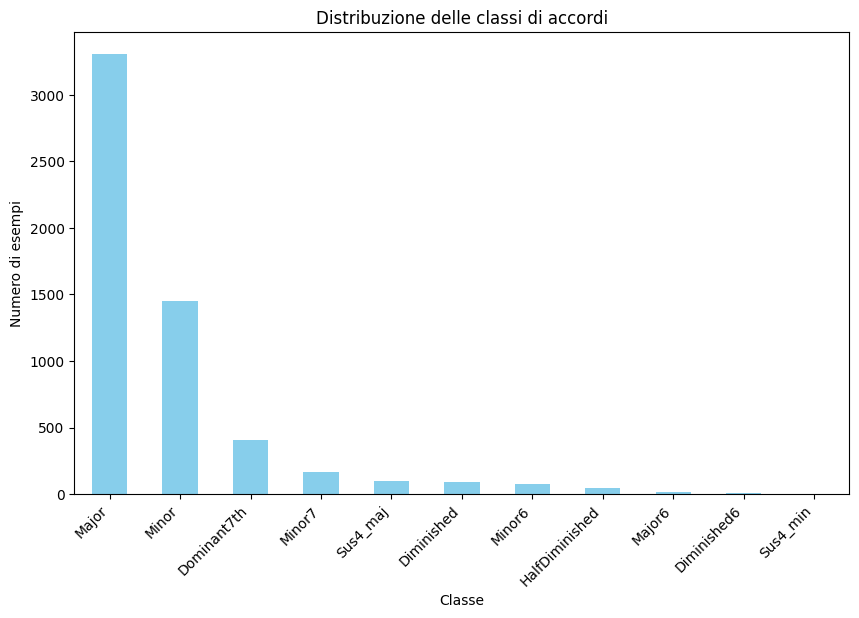

In [99]:

# contiamo quante occorrenze per ogni classe
label_counts = y.value_counts()

# plot
plt.figure(figsize=(10,6))
label_counts.plot(kind='bar', color='skyblue')
plt.title("Distribuzione delle classi di accordi")
plt.xlabel("Classe")
plt.ylabel("Numero di esempi")
plt.xticks(rotation=45, ha='right')
plt.show()

In [154]:
from wittgenstein import RIPPER

def ripper_one_vs_all(x_train, x_test, y_train, y_test):
    result = []
    for chord in y_train.unique():
        # Inizializza il classificatore
        ripper_clf = RIPPER()

        # Train su training set, dichiara pos_class
        ripper_clf.fit(x_train, y_train, pos_class=chord)

        # Predizioni
        predicted_train = ripper_clf.predict(x_train)
        predicted_test = ripper_clf.predict(x_test)

        # Etichette binarie per one-vs-all
        y_train_bin = (y_train == chord)
        y_test_bin = (y_test == chord)

        # Calcolo metriche usando etichette binarie
        metrics_dict = {
            "Chord": chord,
            "Train Accuracy": metrics.accuracy_score(y_train_bin, predicted_train),
            "Train Precision": metrics.precision_score(y_train_bin, predicted_train, zero_division=0),
            "Train Recall": metrics.recall_score(y_train_bin, predicted_train, zero_division=0),
            "Train F1": metrics.f1_score(y_train_bin, predicted_train, zero_division=0),
            "Test Accuracy": metrics.accuracy_score(y_test_bin, predicted_test),
            "Test Precision": metrics.precision_score(y_test_bin, predicted_test, zero_division=0),
            "Test Recall": metrics.recall_score(y_test_bin, predicted_test, zero_division=0),
            "Test F1": metrics.f1_score(y_test_bin, predicted_test, zero_division=0),
        }

        result.append(metrics_dict)

    result_df = pd.DataFrame(result)
    return result_df

In [152]:
# Splitting del dataset
training_data, test_data, training_labels, test_labels = train_test_split(
            x, y, test_size=0.25, random_state=142
        )
chord_ripper = ripper_one_vs_all(training_data, test_data, training_labels, test_labels)

In [ ]:
display(chord_ripper)

NameError: name 'chord_ripper' is not defined

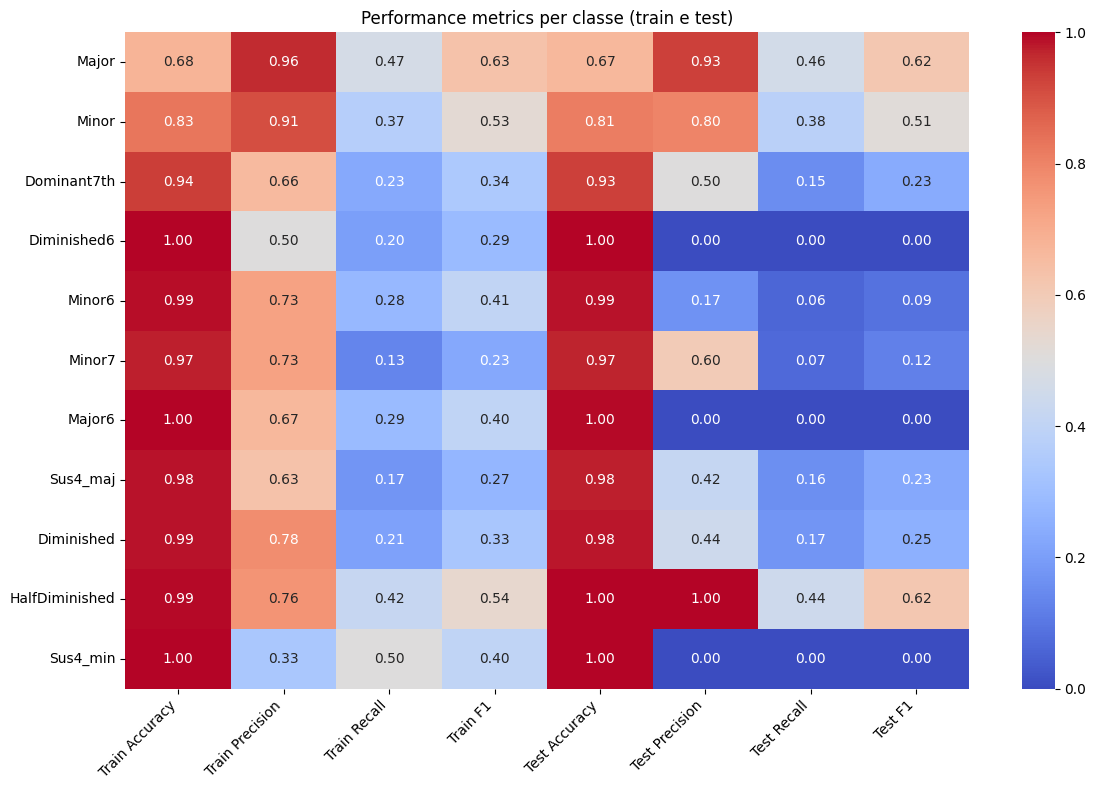

In [155]:
import seaborn as sns

# Selezioniamo le colonne di metriche che vogliamo visualizzare
metrics_to_plot = ["Train Accuracy", "Train Precision", "Train Recall", "Train F1",
                   "Test Accuracy", "Test Precision", "Test Recall", "Test F1"]

# Impostiamo la figura
plt.figure(figsize=(12, 8))

# Creiamo la heatmap
sns.heatmap(chord_ripper[metrics_to_plot], 
            annot=True,          # mostra i valori dentro le celle
            fmt=".2f",           # due decimali
            yticklabels=chord_ripper["Chord"],  # etichette righe = classi
            cmap="coolwarm")     # colormap

plt.title("Performance metrics per classe (train e test)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [149]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

cv_inner = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
cv_outer = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

classifier = DecisionTreeClassifier()
p_grid = {'criterion': ["gini", "entropy"],
          'max_depth': [3, 7, 10],
          'min_samples_leaf': [1, 2, 5]}

history = []
counter = 1

for train_index, test_index in cv_outer.split(x, y):
    print('\nNestedCV: {} of outer fold {}'.format(counter, cv_outer.get_n_splits()))

    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = RandomizedSearchCV(classifier, param_distributions=p_grid,
                               scoring='accuracy', cv=cv_inner)
    model.fit(x_train, y_train)

    pred_test = model.predict(x_test)
    pred_training = model.predict(x_train)

    acc_train = accuracy_score(y_train, pred_training)
    acc_test = accuracy_score(y_test, pred_test)

    print("Best set of parameters:", model.best_params_)
    print("Best inner cv score:", model.best_score_)
    print("Training accuracy:", acc_train)
    print("Test accuracy:", acc_test)

    history.append(acc_test)
    counter += 1

print('\nOverall test performance: {:.3f}'.format(np.mean(history)))

c:\Users\Lorenzo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=4.
c:\Users\Lorenzo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.



NestedCV: 1 of outer fold 4
Best set of parameters: {'min_samples_leaf': 1, 'max_depth': 10, 'criterion': 'gini'}
Best inner cv score: 0.7401129943502824
Training accuracy: 0.8528719397363466
Test accuracy: 0.7431192660550459

NestedCV: 2 of outer fold 4


c:\Users\Lorenzo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.


Best set of parameters: {'min_samples_leaf': 1, 'max_depth': 10, 'criterion': 'gini'}
Best inner cv score: 0.7380581288433227
Training accuracy: 0.8533772652388797
Test accuracy: 0.7542372881355932

NestedCV: 3 of outer fold 4


c:\Users\Lorenzo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=4.


Best set of parameters: {'min_samples_leaf': 5, 'max_depth': 10, 'criterion': 'gini'}
Best inner cv score: 0.7368784469211785
Training accuracy: 0.8072487644151565
Test accuracy: 0.7584745762711864

NestedCV: 4 of outer fold 4


c:\Users\Lorenzo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=4.


Best set of parameters: {'min_samples_leaf': 1, 'max_depth': 10, 'criterion': 'gini'}
Best inner cv score: 0.7338170760010134
Training accuracy: 0.851494469286891
Test accuracy: 0.7492937853107344

Overall test performance: 0.751


In [148]:
from sklearn.neighbors import KNeighborsClassifier

cv_inner = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
cv_outer = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

classifier = KNeighborsClassifier()
p_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 15, 20],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'p': [1, 2]  # serve solo se metric="minkowski"
}

history = []
counter = 1

for train_index, test_index in cv_outer.split(x, y):
    print('\nNestedCV: {} of outer fold {}'.format(counter, cv_outer.get_n_splits()))

    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = RandomizedSearchCV(classifier, param_distributions=p_grid,
                               scoring='accuracy', cv=cv_inner)
    model.fit(x_train, y_train)

    pred_test = model.predict(x_test)
    pred_training = model.predict(x_train)

    acc_train = accuracy_score(y_train, pred_training)
    acc_test = accuracy_score(y_test, pred_test)

    print("Best set of parameters:", model.best_params_)
    print("Best inner cv score:", model.best_score_)
    print("Training accuracy:", acc_train)
    print("Test accuracy:", acc_test)

    history.append(acc_test)
    counter += 1

print('\nOverall test performance: {:.3f}'.format(np.mean(history)))

c:\Users\Lorenzo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=4.
c:\Users\Lorenzo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.



NestedCV: 1 of outer fold 4
Best set of parameters: {'weights': 'distance', 'p': 2, 'n_neighbors': 11, 'metric': 'manhattan'}
Best inner cv score: 0.621939736346516
Training accuracy: 0.9882297551789078
Test accuracy: 0.6541990119971771

NestedCV: 2 of outer fold 4


c:\Users\Lorenzo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.


Best set of parameters: {'weights': 'distance', 'p': 2, 'n_neighbors': 9, 'metric': 'manhattan'}
Best inner cv score: 0.6338001126754575
Training accuracy: 0.9877618263120734
Test accuracy: 0.643361581920904

NestedCV: 3 of outer fold 4


c:\Users\Lorenzo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=4.


Best set of parameters: {'weights': 'uniform', 'p': 2, 'n_neighbors': 3, 'metric': 'manhattan'}
Best inner cv score: 0.5989663886984391
Training accuracy: 0.7787714756413274
Test accuracy: 0.6059322033898306

NestedCV: 4 of outer fold 4


c:\Users\Lorenzo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=4.


Best set of parameters: {'weights': 'uniform', 'p': 2, 'n_neighbors': 5, 'metric': 'manhattan'}
Best inner cv score: 0.5980245476594154
Training accuracy: 0.7168745587196987
Test accuracy: 0.6122881355932204

Overall test performance: 0.629


In [160]:
# Supponiamo che y sia la colonna delle label
counts = y.value_counts()  # Conta quante volte compare ogni classe
rare_labels = counts[counts < 10].index  # Le classi con meno di 10 occorrenze

# Filtra X e y
mask = ~y.isin(rare_labels)
x_filtered = x[mask]
y_filtered = y[mask]

from sklearn.model_selection import StratifiedKFold


all_folds = []
cv_split = StratifiedKFold(n_splits=4, shuffle=True) # or StratifiedKFold
for fold, (train, test) in enumerate(cv_split.split(x_filtered, y_filtered)):
    print("Fold: ", fold)
    print("  Training set size:", len(train), "Test set size:", len(test))
    y_train = y_filtered.iloc[train]
    y_test = y_filtered.iloc[test]
    x_train = x_filtered.iloc[train]
    x_test = x_filtered.iloc[test]
    chord_ripper = ripper_one_vs_all(x_train,x_test,y_train,y_test)

    chord_ripper = ripper_one_vs_all(x_train, x_test, y_train, y_test)
    chord_ripper["Fold"] = fold
    all_folds.append(chord_ripper)

    results_df = pd.concat(all_folds, ignore_index=True)

summary = results_df.groupby("Chord").mean()
display(summary)

Fold:  0
  Training set size: 4243 Test set size: 1415
Fold:  1
  Training set size: 4243 Test set size: 1415
Fold:  2
  Training set size: 4244 Test set size: 1414
Fold:  3
  Training set size: 4244 Test set size: 1414


,Train Accuracy,Train Precision,Train Recall,Train F1,Test Accuracy,Test Precision,Test Recall,Test F1,Fold
Chord,,,,,,,,,
Diminished,0.986155,0.681203,0.233813,0.346143,0.981796,0.201389,0.086957,0.120982,1.5
Dominant7th,0.939673,0.735273,0.245245,0.366596,0.928774,0.506320,0.150626,0.230576,1.5
HalfDiminished,0.994580,0.749291,0.546032,0.628304,0.992223,0.540865,0.422348,0.468947,1.5
Major,0.678801,0.967121,0.466375,0.626798,0.658718,0.936517,0.445751,0.600803,1.5
Major6,0.996171,0.469298,0.241758,0.292875,0.995581,0.364583,0.175000,0.196429,1.5
Minor,0.860553,0.881398,0.529252,0.660212,0.848004,0.846934,0.496850,0.625636,1.5
Minor6,0.989572,0.743778,0.310471,0.429570,0.985861,0.238095,0.067982,0.103810,1.5
Minor7,0.974255,0.759611,0.157554,0.259177,0.970484,0.351190,0.054878,0.093847,1.5
Sus4_maj,0.986450,0.753034,0.362939,0.487724,0.978084,0.324781,0.218462,0.258483,1.5
